today date = 2023-10-25
test start date:  2023-05-17
test end date:  2023-10-25
/home/ubuntu
preparing training data from csv:  /home/ubuntu/gridmet_test_run/all_merged_training.csv
         date       lat         lon  swe_value  station_elevation  elevation  \
0  2017-01-01  37.89748 -119.262434       18.0             9400.0   3057.726   
1  2017-01-02  37.89748 -119.262434       18.0             9400.0   3057.726   
2  2017-01-03  37.89748 -119.262434       18.0             9400.0   3057.726   
3  2017-01-04  37.89748 -119.262434       23.0             9400.0   3057.726   
4  2017-01-05  37.89748 -119.262434       43.0             9400.0   3057.726   

       aspect  curvature      slope  eastness  ...   rmax  rmin   tmmn   tmmx  \
0  114.622729  -0.012519  12.720217 -0.416641  ...   62.2  22.5  260.8  273.0   
1  114.622729  -0.012519  12.720217 -0.416641  ...   71.4  50.8  260.7  265.2   
2  114.622729  -0.012519  12.720217 -0.416641  ...   90.4  49.4  262.7  270.9   
3  114.622729

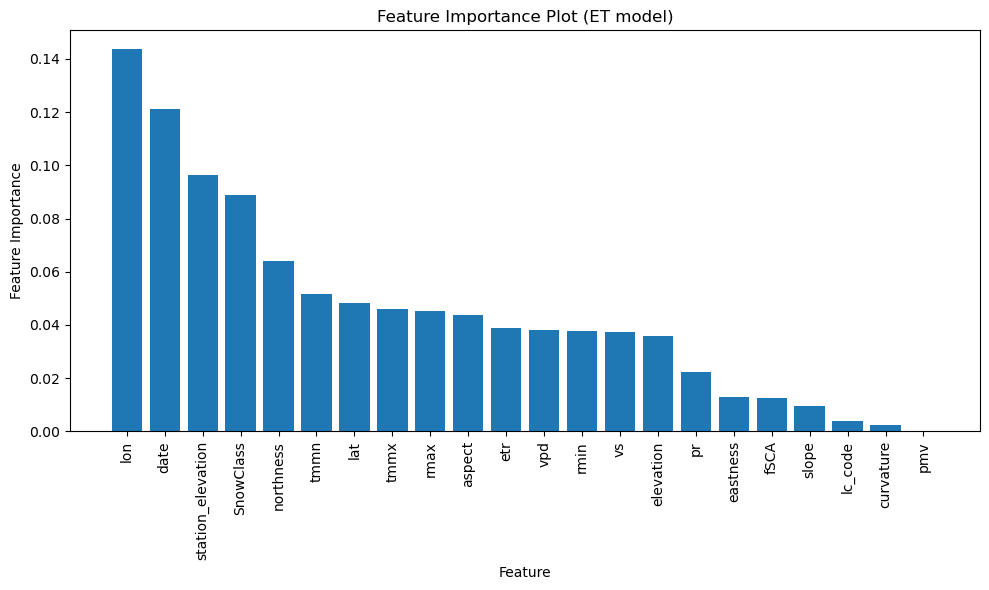

In [1]:
"""
This script defines the ETHole class, which is used for training and evaluating an Extra Trees Regressor model for hole analysis.

Attributes:
    ETHole (class): A class for training and using an Extra Trees Regressor model for hole analysis.

Functions:
    custom_loss(y_true, y_pred): A custom loss function that penalizes errors for values greater than 10.
    get_model(): Returns the Extra Trees Regressor model with specified hyperparameters.
    create_sample_weights(y, scale_factor): Creates sample weights based on target values and a scaling factor.
    preprocessing(): Preprocesses the training data, including data cleaning and feature extraction.
    train(): Trains the Extra Trees Regressor model.
    post_processing(): Performs post-processing, including feature importance analysis and visualization.
"""

import pandas as pd
import joblib
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from model_creation_rf import RandomForestHole
from snowcast_utils import work_dir, month_to_season


working_dir = work_dir

class ETHole(RandomForestHole):
  
    def custom_loss(y_true, y_pred):
        """
        A custom loss function that penalizes errors for values greater than 10.

        Args:
            y_true (numpy.ndarray): True target values.
            y_pred (numpy.ndarray): Predicted target values.

        Returns:
            numpy.ndarray: Custom loss values.
        """
        errors = np.abs(y_true - y_pred)
        
        return np.where(y_true > 10, 2 * errors, errors)

    def get_model(self):
        """
        Returns the Extra Trees Regressor model with specified hyperparameters.

        Returns:
            ExtraTreesRegressor: The Extra Trees Regressor model.
        """
        return ExtraTreesRegressor(n_estimators=200, 
                                   max_depth=None,
                                   random_state=42, 
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   n_jobs=5
                                  )

    def create_sample_weights(self, y, scale_factor, columns):
        """
        Creates sample weights based on target values and a scaling factor.

        Args:
            y (numpy.ndarray): Target values.
            scale_factor (float): Scaling factor for sample weights.

        Returns:
            numpy.ndarray: Sample weights.
        """
        return (y - np.min(y)) / (np.max(y) - np.min(y)) * scale_factor
        # Create a weight vector to assign weights to features - this is not a good idea
#         feature_weights = {'date': 0.1, 'SWE': 1.5, 'wind_speed': 1.5, 'precipitation_amount': 2.0}
#         default_weight = 1.0

#         # Create an array of sample weights based on feature_weights
#         sample_weights = np.array([feature_weights.get(feature, default_weight) for feature in columns])
        #return sample_weights

      
    def preprocessing(self):
        """
        Preprocesses the training data, including data cleaning and feature extraction.
        """
        #training_data_path = f'{working_dir}/final_merged_data_3yrs_cleaned.csv'
        #training_data_path = f'{working_dir}/final_merged_data_3yrs_cleaned_v3.csv'
        training_data_path = f"{working_dir}/all_merged_training.csv"
        print("preparing training data from csv: ", training_data_path)
        data = pd.read_csv(training_data_path)
        print(data.head())
        
        data['date'] = pd.to_datetime(data['date'])
        #reference_date = pd.to_datetime('1900-01-01')
        #data['date'] = (data['date'] - reference_date).dt.days
        # just use julian day
        #data['date'] = data['date'].dt.strftime('%j').astype(int)
        # just use the season to reduce the bias on month or dates
        data['date'] = data['date'].dt.month.apply(month_to_season)
        
        data.replace('--', pd.NA, inplace=True)
        data.fillna(-999, inplace=True)
        
        data = data[(data['swe_value'] != -999)]
        
        # careful this is filling all the n/a values with interpolation
        #data.fillna(method='ffill', inplace=True)
        #print(data.head())
        
        print("get swe statistics")
        print(data["swe_value"].describe())
        
        #data = data.drop('Unnamed: 0', axis=1)
        #data = data.drop('level_0', axis=1)
        #data = data.drop(['date'], axis=1)
        
#         (['lat', 'lon', 'SWE', 'Flag', 'air_temperature_tmmn',
# 'potential_evapotranspiration', 'mean_vapor_pressure_deficit',
# 'relative_humidity_rmax', 'relative_humidity_rmin',
# 'precipitation_amount', 'air_temperature_tmmx', 'wind_speed',
# 'elevation', 'slope', 'curvature', 'aspect', 'eastness', 'northness']
        
        
        X = data.drop('swe_value', axis=1)
      	
        print('required features:', X.columns)
        y = data['swe_value']
        
        print("input features and order: ", X.columns)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.weights = self.create_sample_weights(y_train, scale_factor=30.0, columns=X.columns)

        self.train_x, self.train_y = X_train.to_numpy(), y_train.to_numpy()
        self.test_x, self.test_y = X_test.to_numpy(), y_test.to_numpy()
        self.feature_names = X_train.columns
        
    def train(self):
        """
        Trains the Extra Trees Regressor model.
        """
        self.classifier.fit(self.train_x, self.train_y, sample_weight=self.weights)

    def post_processing(self):
        """
        Performs post-processing, including feature importance analysis and visualization.
        """
        feature_importances = self.classifier.feature_importances_
        feature_names = self.feature_names
        sorted_indices = np.argsort(feature_importances)[::-1]
        sorted_importances = feature_importances[sorted_indices]
        sorted_feature_names = feature_names[sorted_indices]

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(feature_names)), sorted_importances, tick_label=sorted_feature_names)
        plt.xticks(rotation=90)
        plt.xlabel('Feature')
        plt.ylabel('Feature Importance')
        plt.title('Feature Importance Plot (ET model)')
        plt.tight_layout()
        feature_png = f'{work_dir}/testing_output/et-model-feature-importance-latest.png'
        plt.savefig(feature_png)
        print(f"Feature image is saved {feature_png}")

# Instantiate ETHole class and perform tasks
hole = ETHole()
hole.preprocessing()
hole.train()
hole.test()
hole.evaluate()
hole.save()
hole.post_processing()

In [3]:
df = pd.read_csv("/home/ubuntu/gridmet_test_run/testing_points.csv")
# Choose 10 random rows from the DataFrame
random_rows = df.sample(n=10, random_state=1)  # Set a random_state for reproducibility

# Print the randomly selected rows
print(random_rows)

     Latitude  Longitude
649    37.912   -119.564
265    38.416   -119.276
111    38.632   -118.772
301    38.380   -118.988
339    38.308   -119.636
559    38.056   -118.772
742    37.804   -119.240
202    38.488   -119.528
600    37.984   -119.312
680    37.876   -119.456
